In [1]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
'''Importing Data Manipulattion Moduls'''
import numpy as np
import pandas as pd
from scipy import stats
import os, gc

'''Seaborn and Matplotlib Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")                    
%matplotlib inline

'''plotly Visualization'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True)

'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

In [3]:
pwd

'C:\\Users\\ZiYang'

In [4]:
building6560 = pd.read_csv('C:/Users/ZiYang/Documents/kaggle/ashrae-energy-prediction/train_df_building.csv')
weather6560 = pd.read_csv('C:/Users/ZiYang/Documents/kaggle/ashrae-energy-prediction/weather_train_filled.csv')
bold('**Preview of building data 6560**')
display(building6560.head(3))
bold('**Preview of Weather data 6560**')
display(weather6560.head(3))

**Preview of building data 6560**

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,week,hour,day,weekday,month
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,53,0,1,4,1
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,53,0,1,4,1
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,53,0,1,4,1


**Preview of Weather data 6560**

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,timestamp,wind_direction,wind_speed,week,hour,day,weekday,month
0,0,25.0,6.000000,20.0,-0.173913,1019.7,2016-01-01 00:00:00,0.0,0.0,53,0,1,4,1
1,0,24.4,4.285714,21.1,-1.000000,1020.2,2016-01-01 01:00:00,70.0,1.5,53,1,1,4,1
2,0,22.8,2.000000,21.1,0.000000,1020.2,2016-01-01 02:00:00,0.0,0.0,53,2,1,4,1


In [5]:
'''Dimension of train and test data'''
bold('**Shape of data**')
print('Dimension of building:', building6560.shape) 
print('Dimension of Weather:',weather6560.shape) 

**Shape of data**

Dimension of building: (20216100, 12)
Dimension of Weather: (140544, 14)


In [6]:
'''Merging datasets'''
building6560 = building6560.merge(weather6560, on = ['site_id', 'timestamp'], how = 'left')

In [7]:
display(building6560.head(3))

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,week_x,hour_x,day_x,...,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,week_y,hour_y,day_y,weekday_y,month_y
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,53,0,1,...,20.0,-0.173913,1019.7,0.0,0.0,53,0,1,4,1
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,53,0,1,...,20.0,-0.173913,1019.7,0.0,0.0,53,0,1,4,1
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,53,0,1,...,20.0,-0.173913,1019.7,0.0,0.0,53,0,1,4,1


In [8]:
'''Function to reduce the DF size'''
# source: https://www.kaggle.com/kernels/scriptcontent/3684066/download

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
        end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
building6560 = reduce_mem_usage(building6560)

Memory usage of dataframe is 3855.92 MB
Memory usage after optimization is: 906.52 MB
Decreased by 76.5%


In [10]:
'''Variable Description'''
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary
bold('**Variable Description of  train Data:**')
description(building6560)

**Variable Description of  train Data:**

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,category,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float32,0,1688175,0,0,0
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,int32,0,1397,7432,2720,5376
7,week_x,int8,0,53,53,53,53
8,hour_x,int8,0,24,0,0,0
9,day_x,int8,0,31,1,1,1


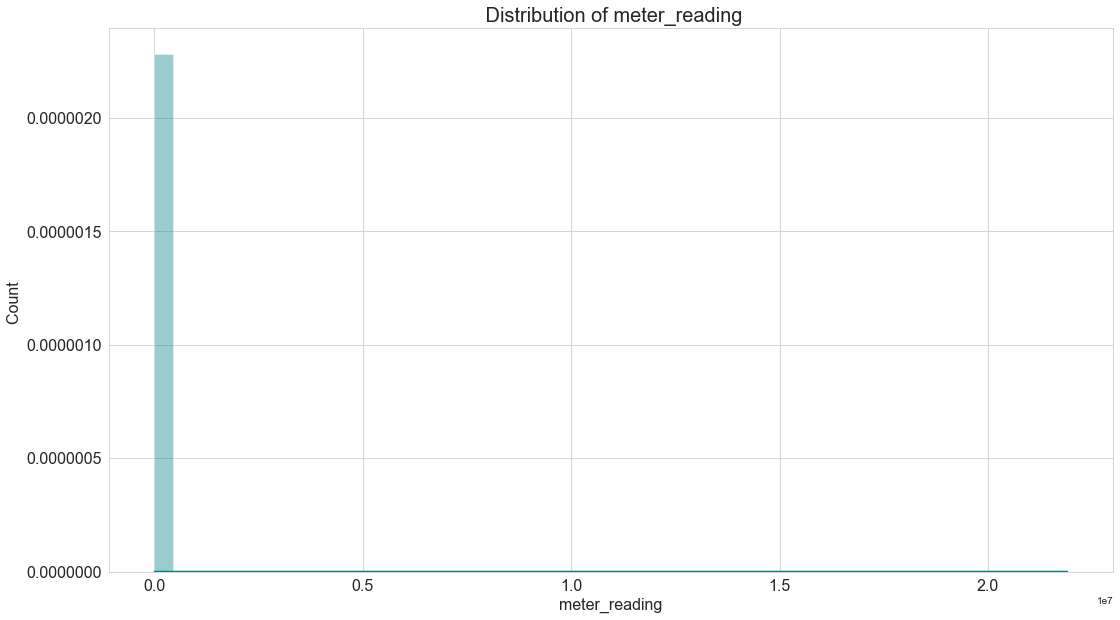

In [11]:
'''Function to distribution plot'''
def distplot(variable, color):
    global ax
    font_size = 16
    title_size = 20
    plt.rcParams['figure.figsize'] = (18, 10)
    ax = sns.distplot(variable, color = color)
    plt.xlabel('%s' %variable.name, fontsize = font_size)
    plt.ylabel('Count ', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.title(' Distribution of '+'%s' %variable.name, fontsize = title_size)
    plt.show()
    
    '''Distribution of the Meter Reading'''
distplot(building6560['meter_reading'], 'teal')

In [12]:
'''Summary of meter reading'''
building6560['meter_reading'].describe()

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

**Distribution after log tranformation**

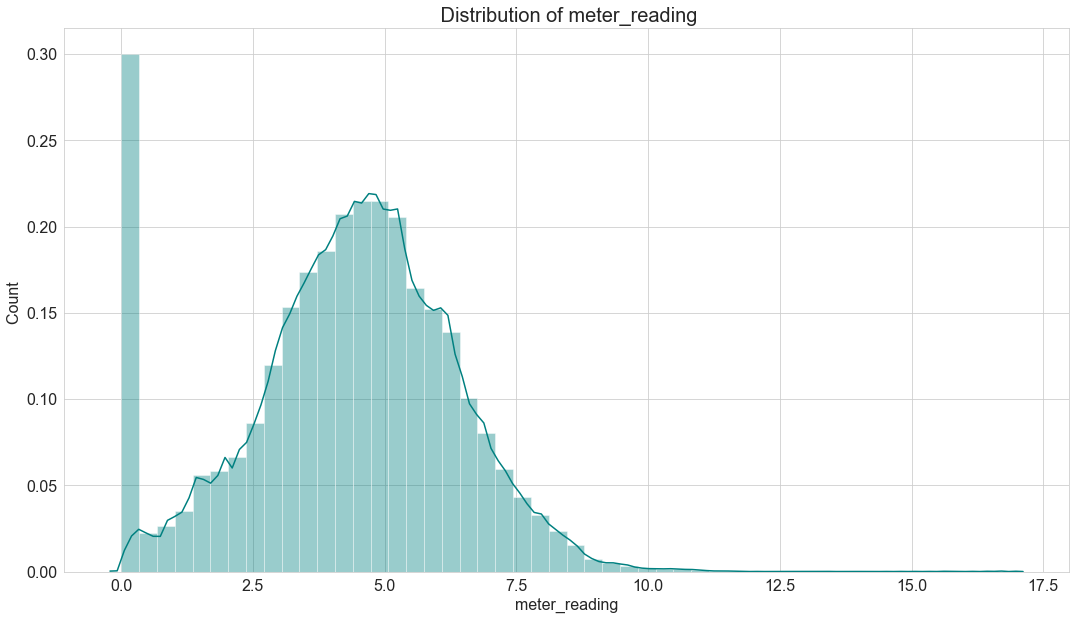

In [13]:
'''Log tranformation of meter_reading'''
building6560['meter_reading'] = np.log1p(building6560['meter_reading'])

bold('**Distribution after log tranformation**')
distplot(building6560['meter_reading'], 'teal')

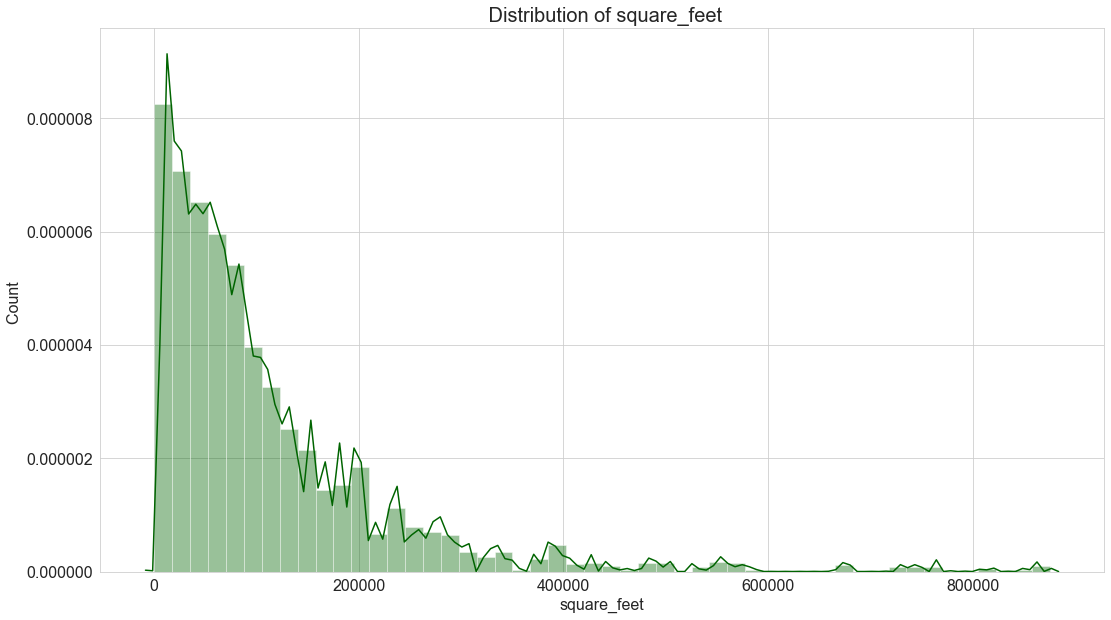

In [14]:
'''Distribution of the Meter Reading'''
distplot(building6560['square_feet'], 'darkgreen')

**Distribution after log tranformation**

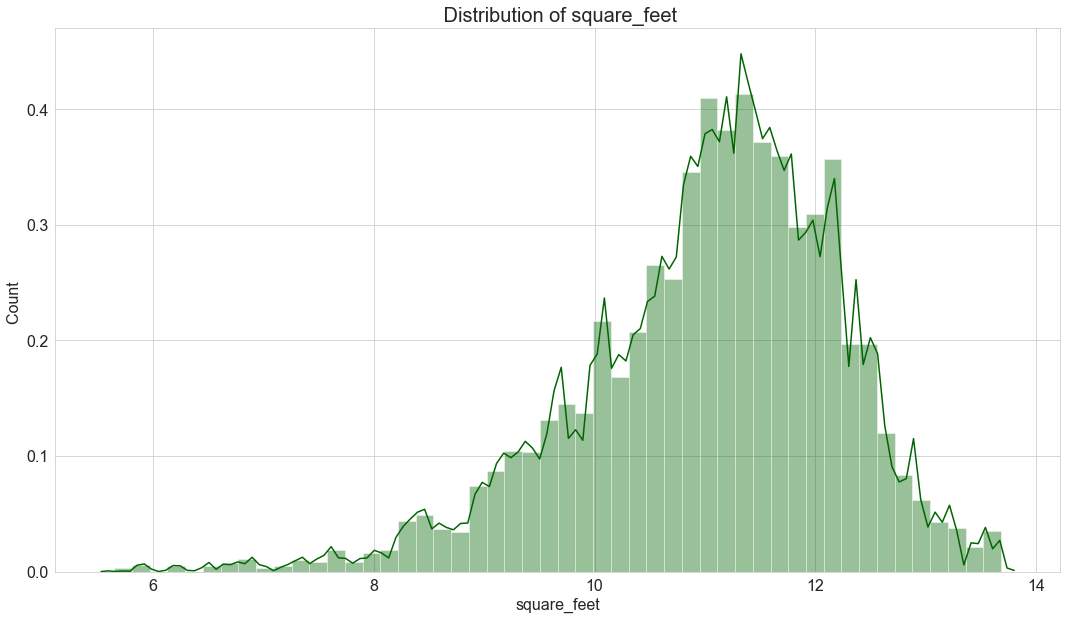

In [15]:
'''Log tranformation of meter_reading'''
building6560['square_feet'] = np.log1p(building6560['square_feet'])
bold('**Distribution after log tranformation**')
distplot(building6560['square_feet'], 'darkgreen')

**ELECTRICITY THE MOST FREQUENT METER TYPE MEASURED**

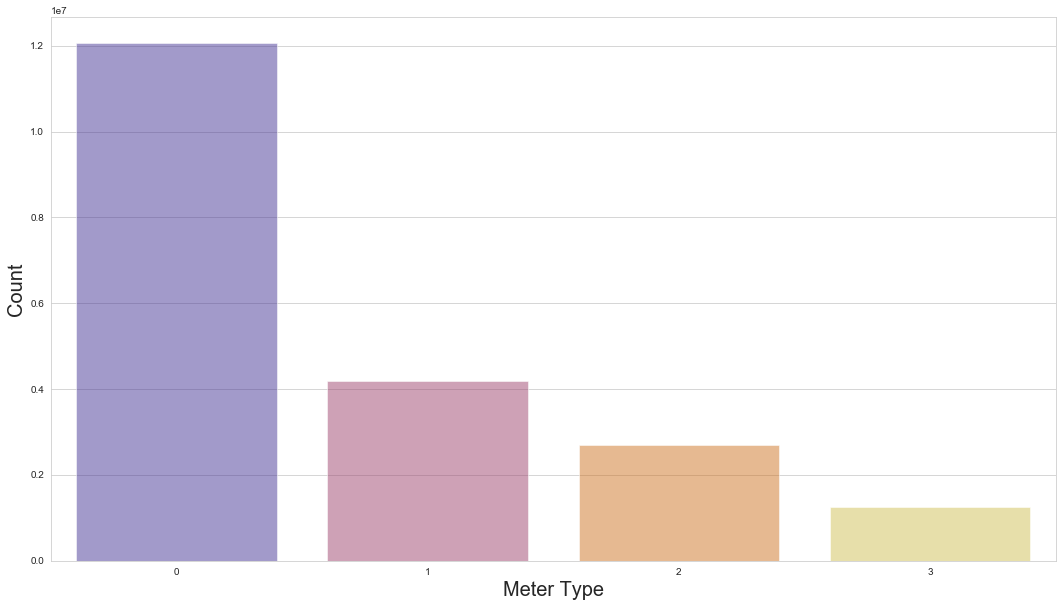

In [16]:
bold('**ELECTRICITY THE MOST FREQUENT METER TYPE MEASURED**')
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.countplot(data = building6560, x ='meter', palette = 'CMRmap', alpha = 0.5)
ax.set_ylabel('Count', fontsize = 20)
ax.set_xlabel('Meter Type', fontsize = 20)
plt.show()

**THE STEAM METER TYPE IS THE LEAST EFFICIENT, ELECTRICITY THE MOST EFFICIENT**

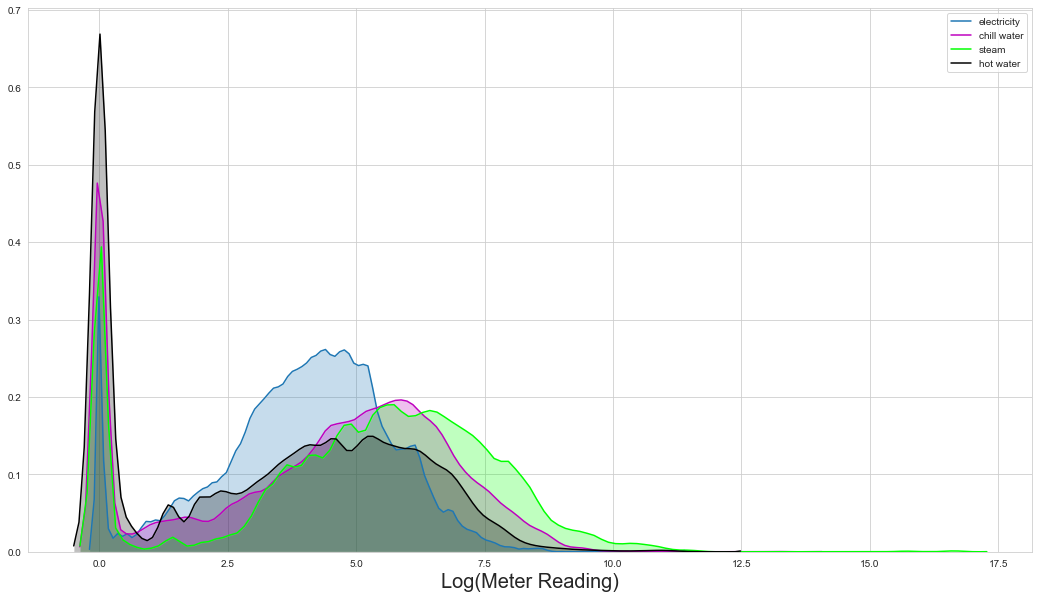

In [17]:
bold('**THE STEAM METER TYPE IS THE LEAST EFFICIENT, ELECTRICITY THE MOST EFFICIENT**')
plt.rcParams['figure.figsize'] = (18, 10)

temp_df = building6560[building6560["meter"]==0]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="electricity")
temp_df = building6560[building6560["meter"]==1]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="chill water", color = 'm')
temp_df = building6560[building6560["meter"]==2]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="steam", color = 'lime')
temp_df = building6560[building6560["meter"]==3]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="hot water", color = 'k')
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
plt.show()

**READINGS HIGHEST DURING THE MIDDLE OF THE DAY**

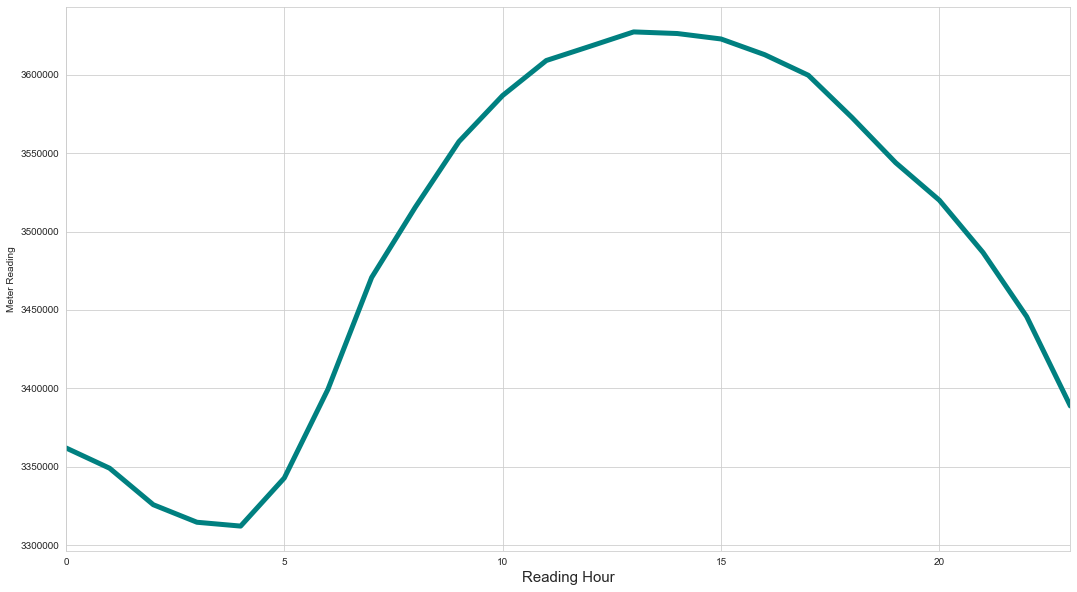

In [18]:
bold('**READINGS HIGHEST DURING THE MIDDLE OF THE DAY**')
plt.rcParams['figure.figsize'] = (18,10)
temp_df = building6560.groupby('hour_x').meter_reading.sum()
temp_df.plot(linewidth = 5, color = 'teal')
plt.xlabel('Reading Hour', fontsize = 15)
plt.ylabel('Meter Reading')
plt.show()

**UTILITIES AND HEALTHCARE HAVE THE HIGHEST READINGS**

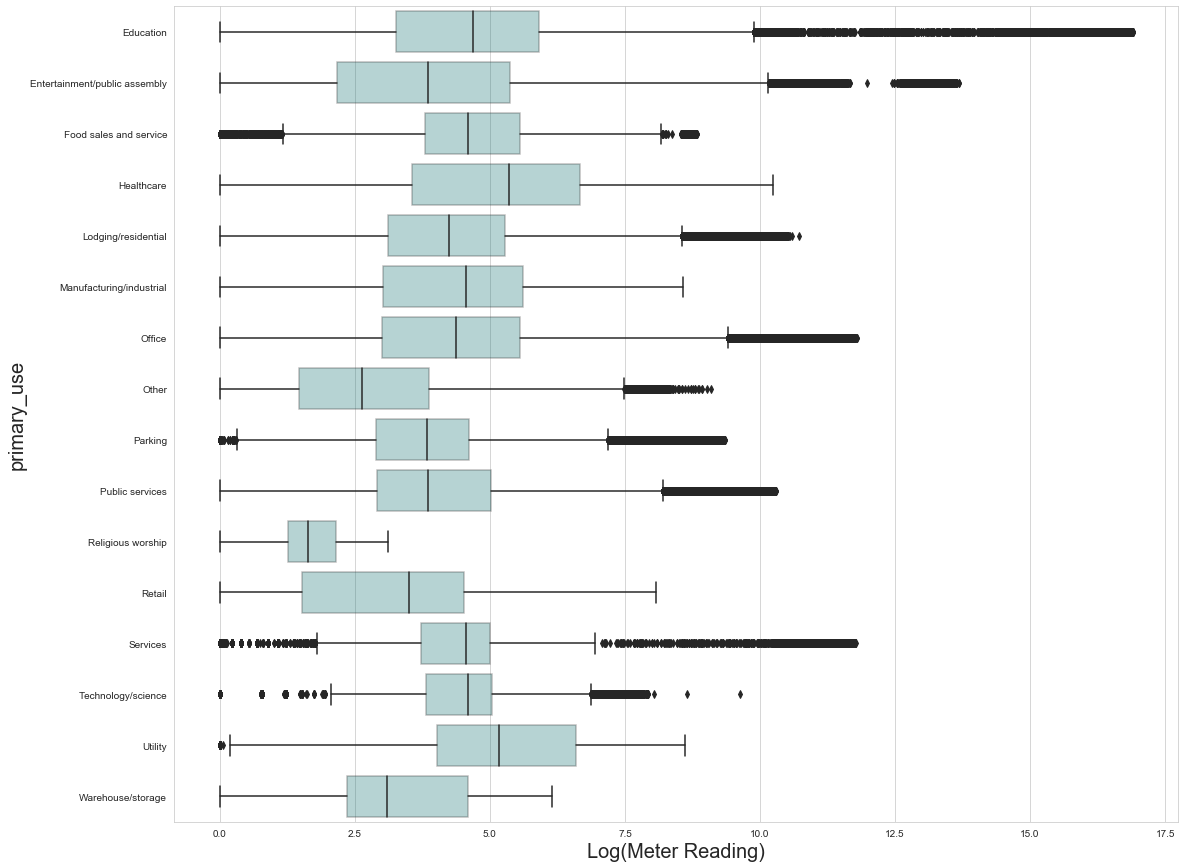

In [19]:
bold('**UTILITIES AND HEALTHCARE HAVE THE HIGHEST READINGS**')
plt.rcParams['figure.figsize'] = (18, 15)
ax = sns.boxplot(data = building6560, y ='primary_use', x = 'meter_reading', color = 'teal', boxprops=dict(alpha=.3))
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
ax.set_ylabel('primary_use', fontsize = 20)
plt.show()

In [20]:
building6560 = building6560.drop(["week_y","hour_y","day_y","weekday_y","month_y","week_x","hour_x","day_x","weekday_x","month_x"],axis = 1)

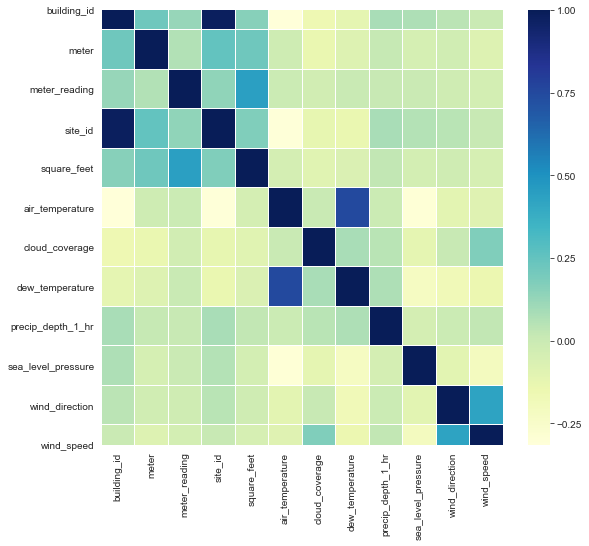

In [21]:
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(building6560.corr(), ax = ax, cmap ="YlGnBu", linewidths = 0.1)

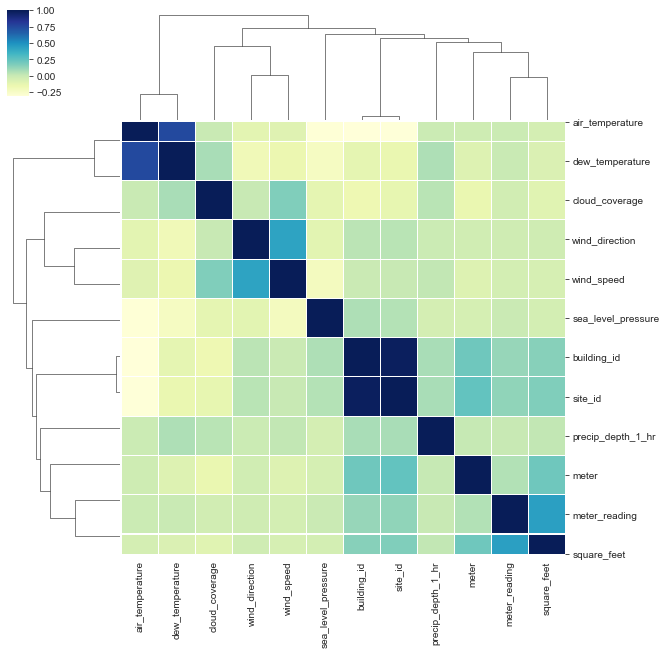

In [22]:
cg = sns.clustermap(building6560.corr(), cmap ="YlGnBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
cg 